# RISTEK Assignment 1

- Bryan Tjandra

# Prepare

Initial process based on RISTEK Class, from loading data until making prediction with catboost

In [ ]:
pip install catboost --quiet

In [ ]:
import numpy as np
import pandas as pd

import catboost as cb
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from typing import Any
from typing import Optional

from catboost import CatBoostClassifier

from sklearn.base import ClassifierMixin

In [ ]:
train = pd.read_csv("train.csv", index_col=0)
train_original = pd.read_csv("train_original.csv", index_col=0)
validation = pd.read_csv("validation.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

In [ ]:
sc2map = {'2000 Atmospheres LE': '2k',
 '2000 атмосфер РВ': '2k',
 '2000 애트모스피어 - 래더': '2k',
 'Atmosphère 2\xa0000 EC': '2k',
 'Beckett Industries LE': 'beckett',
 'Berlingrad EC': 'berlingrad',
 'Berlingrad LE': 'berlingrad',
 'Blackburn EE': 'blackburn',
 'Blackburn LE': 'blackburn',
 'Curious Minds LE': 'curious',
 'Glittering Ashes LE': 'glittering',
 'Hardwire LE': 'hardwire',
 'Jagannatha LE': 'jagannatha',
 'Lightshade LE': 'lightshade',
 'Mentes curiosas EE': 'curious',
 'Oxide LE': 'oxide',
 'Pride of Altaris LE': 'pride',
 'Romanticide LE': 'romanticide',
 '[ESL] Berlingrad': 'berlingrad',
 '[ESL] Blackburn': 'blackburn',
 '[ESL] Curious Minds': 'curious',
 '[ESL] Glittering Ashes': 'glittering',
 '[ESL] Hardwire': 'hardwire',
 '[ESL] Pride of Altaris': 'pride',
 '[TLMC14] Blackburn': 'blackburn',
 '[TLMC15] Berlingrad': 'berlingrad',
 '[TLMC15] Curious Minds': 'curious',
 '[TLMC15] Glittering Ashes': 'glittering',
 '[TLMC15] Hardwire': 'hardwire',
 '[TLMC15] Pride of Altaris': 'pride',
 'Берлинград РВ': 'berlingrad',
 '世界主宰-天梯版': 'jagannatha',
 '光影交错-天梯版': 'lightshade',
 '大气2000-天梯版': '2k',
 '新奇之地-天梯版': 'curious',
 '柏林加德-天梯版': 'berlingrad',
 '硬线-天梯版': 'hardwire',
 '紫晶浪漫-天梯版': 'romanticide',
 '贝克特工业-天梯版': 'beckett',
 '锈化山巅-天梯版': 'oxide',
 '闪烬平原-天梯版': 'glittering',
 '黑色燃烧-天梯版': 'blackburn',
 '글리터링 애쉬즈 - 래더': 'glittering',
 '베를린그라드 - 래더': 'berlingrad',
 '블랙번 - 래더': 'blackburn',
 '큐리어스 마인즈 - 래더': 'curious',
 '프라이드 오브 알타리스 - 래더': 'pride',
 '하드와이어 - 래더': 'hardwire'}

def preprocess_base(df):
    df = df.copy()
    df["p1_winner"] = df["winner"] == 1
    df["p2_winner"] = df["winner"] == 2

    df["played_at"] = pd.to_datetime(df["played_at"])

    df["map"] =  df.map.apply(lambda x: sc2map[x])

    return df.drop(columns=["winner"])

train = preprocess_base(train)
validation = preprocess_base(validation)
test = preprocess_base(test)
train_original = preprocess_base(train_original)

In [ ]:
class CatBoostModelWithEachRacePrediction(ClassifierMixin):
    def __init__(self, **kwargs):
        self.estimator = CatBoostClassifier(verbose=100, cat_features=["tournament", "map"], **kwargs)

    def process_data(self, X):
        X = X.copy()

        X_stacked = X.copy()
        X_p1, X_p2 = self.switch_p1_p2(X_stacked)
        X_stacked = pd.concat([X_p1, X_p2])

        y_stacked = X_stacked.pop("p1_race")

        return X_stacked.drop(columns=["p2_race", "matchup"], errors="ignore"), y_stacked, X_stacked["matchup"]

    def switch_p1_p2(self, X):
        X = X.copy()

        col_names = X.columns.values
        p1_cols = [col for col in col_names if "p1" in col]
        p2_cols = [col for col in col_names if "p2" in col]
        other_cols = [col for col in col_names if "p1" not in col and "p2" not in col]

        X_original = X[other_cols + p1_cols + p2_cols].copy()
        X_switched = X[other_cols + p2_cols + p1_cols].copy()
        X_switched.columns = X_original.columns
        return X_original, X_switched

    def fit(self, X, y = None, **kwargs):
        X_stacked, y_stacked, _ = self.process_data(X)
        self.estimator.fit(X_stacked, y_stacked, **kwargs)

    def predict(self, X):
        matchup_dict = {
            "Terran": {
                "Terran": "TvT",
                "Zerg": "TvZ",
                "Protoss": "TvP"
            },
            "Protoss": {
                "Protoss": "PvP",
                "Zerg": "PvZ",
                "Terran": "TvP"
            },
            "Zerg": {
                "Zerg": "ZvZ",
                "Protoss": "PvZ",
                "Terran": "TvZ"
            }
        }

        X_p1, X_p2 = self.switch_p1_p2(X)
        pred_p1 = self.estimator.predict(X_p1)
        pred_p2 = self.estimator.predict(X_p2)
        return [matchup_dict[p1[0]][p2[0]] for p1, p2 in zip(pred_p1, pred_p2)]

In [ ]:
params = {"colsample_bylevel": 0.084,
"l2_leaf_reg": 0.15626097454354632,
"depth": 9,
"boosting_type": 'Plain',
"bootstrap_type": 'Bayesian',
"min_data_in_leaf": 5,
"one_hot_max_size": 15,
"bagging_temperature": 0.04}

clf = CatBoostModelWithEachRacePrediction(**params)
clf.fit(train)

0:	learn: 1.0819036	total: 55.2ms	remaining: 55.2s
100:	learn: 0.4113400	total: 1.44s	remaining: 12.8s
200:	learn: 0.2191099	total: 2.62s	remaining: 10.4s
300:	learn: 0.1237280	total: 3.94s	remaining: 9.14s
400:	learn: 0.0729347	total: 5.18s	remaining: 7.75s
500:	learn: 0.0451170	total: 7.49s	remaining: 7.46s
600:	learn: 0.0300153	total: 10.6s	remaining: 7.05s
700:	learn: 0.0207822	total: 14.4s	remaining: 6.14s
800:	learn: 0.0154548	total: 17.8s	remaining: 4.43s
900:	learn: 0.0117096	total: 21.6s	remaining: 2.38s
999:	learn: 0.0092001	total: 25.9s	remaining: 0us


In [ ]:
pred = clf.predict(test)

In [ ]:
sub = test.reset_index()[["id"]].copy().set_index('id')
sub["matchup"] = pred
sub.to_csv("submission1.csv", index=False)
sub

,matchup
id,
486d95087ff4445da692067dfdbd3870,TvP
2de9f70785c848f8bb580f188c4f0302,TvP
38ca5b10579f4dc9b7d5b54c5271afab,TvP
bf780984dd2f403ba3668a2997b89841,PvZ
8c59ca38e232444bb30648cc9f2d221e,PvZ
...,...
4969f529046c418ab915071957a94693,PvP
2fca4fed571e4d15ae0bf1b321702edf,PvP
27b0d332225b4c74937f8dc5f6aabbff,TvP


## tes

In [ ]:
from tensorflow import keras
from keras import layers
from keras import losses
from keras import backend as K

# Stackoverflow references
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Callback function
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

# Callback for plotting loss
tensor_board = TensorBoard(log_dir='./Graph', histogram_freq=1,
                            write_graph=True, write_images=True)

# Callback for reducing learning rate
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_F1', 
    factor = 0.5,   
    patience = 15, 
    verbose = 1)

early_stopper = EarlyStopping(monitor='val_loss', patience=20,min_delta=0.0001)

In [ ]:
class NeuralNetworkWithEachRacePrediction(ClassifierMixin):
    def __init__(self):
        self.estimator = keras.Sequential([
                        # Hidden layer
                        layers.Dense(16, activation='elu', input_shape=(58, )),
                        layers.Dense(16, activation='elu'),
                        # Output layer
                        layers.Dense(3, activation='softmax')])
        self.estimator.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                            loss=losses.CategoricalCrossentropy(), metrics=[F1])

    
    def categoric_data(self, X):
        categorical_features = ["tournament", "map"]
        numeric_features = [col for col in X.columns if col not in categorical_features]

        numeric_transformer = Pipeline(
            steps=[("scaler", StandardScaler())]
        )
        categorical_transformer = OneHotEncoder(handle_unknown="ignore")
        self.preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer, categorical_features),
            ]
        )

        preprocess_X = self.preprocessor.fit_transform(X)
        return preprocess_X

    def process_data(self, X):
        X = X.copy()

        X_stacked = X.copy()
        X_p1, X_p2 = self.switch_p1_p2(X_stacked)
        X_stacked = pd.concat([X_p1, X_p2])

        y_stacked = X_stacked.pop("p1_race")

        return X_stacked.drop(columns=["p2_race", "matchup","played_at"], errors="ignore"), y_stacked

    def switch_p1_p2(self, X):
        X = X.copy()

        col_names = X.columns.values
        p1_cols = [col for col in col_names if "p1" in col]
        p2_cols = [col for col in col_names if "p2" in col]
        other_cols = [col for col in col_names if "p1" not in col and "p2" not in col]

        X_original = X[other_cols + p1_cols + p2_cols].copy()
        X_switched = X[other_cols + p2_cols + p1_cols].copy()
        X_switched.columns = X_original.columns
        return X_original, X_switched

    def fit(self, X, y = None):
        X_stacked, y_stacked = self.process_data(X)

        preprocess_X = self.categoric_data(X_stacked)
        y_stacked = y_stacked.apply(self.replace_target)
        y_stacked = keras.utils.to_categorical(y_stacked)
        self.estimator.fit(preprocess_X, y_stacked, validation_split=0.2, epochs=100, batch_size=16, shuffle=True,
                        callbacks=[reduce_lr])
    
    def replace_target(self, y):
        lst = ['Protoss', "Terran", "Zerg"]
        return lst.index(y)

    def replace_predict(self, y):
        lst = ['Protoss', "Terran", "Zerg"]
        return lst[y]

    def predict(self, X):
        matchup_dict = {
            "Terran": {
                "Terran": "TvT",
                "Zerg": "TvZ",
                "Protoss": "TvP"
            },
            "Protoss": {
                "Protoss": "PvP",
                "Zerg": "PvZ",
                "Terran": "TvP"
            },
            "Zerg": {
                "Zerg": "ZvZ",
                "Protoss": "PvZ",
                "Terran": "TvZ"
            }
        }

        X.drop(columns=["played_at"], errors="ignore", inplace=True)
        X_p1, X_p2 = self.switch_p1_p2(X)
        X_p1 = self.preprocessor.transform(X_p1)
        X_p2 = self.preprocessor.transform(X_p2)

        pred_p1 = self.estimator.predict(X_p1).argmax(axis=1)
        pred_p2 = self.estimator.predict(X_p2).argmax(axis=1)

        pred_p1 = pd.Series(pred_p1).apply(self.replace_predict)
        pred_p2 = pd.Series(pred_p2).apply(self.replace_predict)
        return [matchup_dict[p1][p2] for p1, p2 in zip(pred_p1, pred_p2)]

    def classes_(self):
        return self.estimator.classes_

In [ ]:
nn = NeuralNetworkWithEachRacePrediction()
nn.fit(train_original)

Epoch 1/100
83/83 [==============================] - 1s 5ms/step - loss: 0.9692 - F1: 0.3913 - val_loss: 0.8204 - val_F1: 0.5567 - lr: 0.0010
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 0.7345 - F1: 0.6380 - val_loss: 0.6901 - val_F1: 0.6940 - lr: 0.0010
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6435 - F1: 0.7057 - val_loss: 0.6217 - val_F1: 0.7467 - lr: 0.0010
Epoch 4/100
83/83 [==============================] - 0s 4ms/step - loss: 0.5909 - F1: 0.7370 - val_loss: 0.5870 - val_F1: 0.7636 - lr: 0.0010
Epoch 5/100
83/83 [==============================] - 0s 4ms/step - loss: 0.5558 - F1: 0.7539 - val_loss: 0.5608 - val_F1: 0.7904 - lr: 0.0010
Epoch 6/100
83/83 [==============================] - 0s 5ms/step - loss: 0.5214 - F1: 0.7736 - val_loss: 0.5411 - val_F1: 0.7828 - lr: 0.0010
Epoch 7/100
83/83 [==============================] - 0s 5ms/step - loss: 0.4949 - F1: 0.7892 - val_loss: 0.5304 - val_F1: 0.7953 - lr: 0.0010
Epoch 

# Preprocess

Make a new dataframe consists of several features and their extension from played at and tournament.

Then sort it, to predict matchup with the data leakage 

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv("train_original.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

train["played_at"] = pd.to_datetime(train["played_at"])
test["played_at"] = pd.to_datetime(test["played_at"])

combined = pd.concat([train, test])
combined = combined.sort_values(by="played_at")
combined = combined[["played_at","tournament","game_length","matchup"]]
combined.tail()

,played_at,tournament,game_length,matchup
id,,,,
c5f66ca10de24b19a07f5a474ea03c33,2022-02-27 20:04:17+00:00,IEM Katowice,376,NaN
6ffc084fa1354cc58698a3f04d997f90,2022-02-27 20:18:07+00:00,IEM Katowice,740,ZvZ
dd60d11dd03d464db0527dff2363792c,2022-02-27 20:29:09+00:00,IEM Katowice,591,NaN
0b680807813d48e19e962f9462097060,2022-02-27 20:42:42+00:00,IEM Katowice,420,ZvZ
52a569b72a9648f587a8513879332dd7,2022-02-27 21:05:35+00:00,IEM Katowice,1264,ZvZ


Make a function to replace a target from string to number and vice versa

In [ ]:
import math

def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

target = ['TvZ', 'TvP', 'ZvZ', 'PvZ', 'TvT', 'PvP']

def replace_target(x):
  """
  TvZ -> 0
  """
  if (str(x)!= 'nan') & (not isfloat(x)):
    return target.index(x)
  else:
    return x

def replace_pred(x):
  """
  0 -> TvZ
  """
  if isfloat(x) & (str(x)!='nan'):
      return target[int(float(x))]
  else:
      return x

Create new feature that represents time difference between previous and next game

In [ ]:
combined['matchup'] = combined['matchup'].apply(replace_target)
combined["length"] = combined.game_length/60
diff = (combined["played_at"].values[1:] - combined["played_at"].values[0:-1]).astype(float)/60000000000
combined["diff"] = np.append(diff,[0])
combined["diff"].head()

id
1f6693acf0e04a4882457ad3a4a33c81       31.600000
aaf73dbefbdd44f78fa6c5153721b025        9.000000
a761f27634e54969bf81ee22af0320f3        8.766667
0db2a5fa960d4a76ba338976f2548efd    10105.933333
8c2a729d327141b8963af1caed3255ec        7.433333
Name: diff, dtype: float64

Analyze the distribution of the game time difference

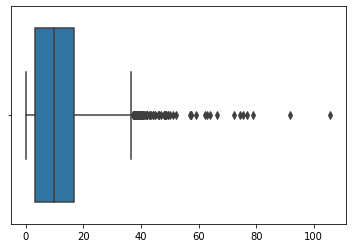

In [ ]:
import seaborn as sns
diff = diff[diff<200]
sns.boxplot(diff)

From the histogram , we can see that , the tournament is divided into 5 sections

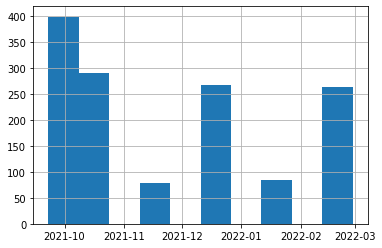

In [ ]:
combined["played_at"].hist()

Make new features
* label -> feature that represents the section that the game belongs to, ex: from the above , there are 5 sections , each section could have an inner section again (ex: we set label a,b,c,d,e,..). Or maybe it will have an innr section again that we can split (ex: a0, a1, a2, ..., b0,b1 ,...)

* matchup_temp -> the target that the catboost model predict for the test (used for the comparison of the predicted value from leakage)



In [ ]:
combined["played_at"] = pd.to_datetime(combined.played_at).dt.tz_localize(None)
combined["label"] = np.NaN
combined['matchup_temp'] = np.NaN

Submission file from the "Prepare" session. We take the predicted matchup and assign it to matchup_temp

In [ ]:
sub = test.reset_index()[["id"]].copy().set_index('id')
sub["matchup"] = pred
combined.loc[test.index, "matchup_temp"] = pd.Series(sub['matchup']).apply(replace_target).values

Based from the histogram, we split the tournament into 5 sessions

In [ ]:
# Parse 5 tournament session

first = combined[combined["played_at"]< pd.to_datetime("2021-11-01")]
second = combined[(combined["played_at"]> pd.to_datetime("2021-11-01")) & (combined["played_at"]< pd.to_datetime("2021-12-01"))]
third = combined[(combined["played_at"]> pd.to_datetime("2021-12-01")) & (combined["played_at"]< pd.to_datetime("2022-01-01"))]
fourth = combined[(combined["played_at"]> pd.to_datetime("2022-01-01")) & (combined["played_at"]< pd.to_datetime("2022-02-01"))]
fifth = combined[(combined["played_at"]> pd.to_datetime("2022-02-01"))]

Split each session into several groups (ex: label a,b,c,d,e,...)

In [ ]:
import string
alphabet = list(string.ascii_lowercase) + list(string.ascii_uppercase)

def set_wider_range_label():
  for j in [first, second, third, fourth, fifth]:
    idx=0
    try:  
      for i in alphabet:
        while j["diff"][idx] < 55:
          j.iloc[idx,-2] = i
          idx+=1
        j.iloc[idx,-2] = i
        idx+=1
    except:
      pass

set_wider_range_label()

Split each groups to a smaller one (if possible) ex:a0,a1,a2,...  . We do that from checking the duration difference between games.

In [ ]:
def set_narrower_range_label():
  for j in [first, second, third, fourth, fifth]:
    for k in alphabet:
          temp = j[j['label']==k]
          to_split = temp[temp["diff"] > (temp["length"].max()+15)]
          if to_split.shape[0] > 1:
              for i in range(to_split.shape[0]):
                  if i==0:
                      j.loc[temp.index.values[0]:to_split.index.values[0],'label'] = k + str(i)
                  else:
                      j.loc[to_split.index.values[i-1]:to_split.index.values[i], 'label'] = k+str(i)
                      val = j[j['label']==k+str(i)]
                      j.loc[val.iloc[0:1].index.values,'label'] = k+str(i-1)

set_narrower_range_label()

If each group within the label k has exactly one unique value, we can fill all of it with that value

In [ ]:
def fill_single_label():
  for j in [first, second, third, fifth]:
    for i in j['label'].unique():
        tmp = j.loc[:,'matchup'][j['label']==i].unique()
        if len(tmp)==2:
          idx = (j.loc[:,'matchup'][(j['label']==i) & (j['matchup'].isnull())].index).to_list()
          if tmp.astype(str)[0] != 'nan':
            sub.loc[idx,'matchup'] = tmp.astype(str)[0]
          else:
            sub.loc[idx,'matchup'] = tmp.astype(str)[1]

fill_single_label()

Make a new feature:
* next not null -> index where next matchup value is not null
* before not null -> index where previous matchup value is not null
* number -> the index (in a number)

In [ ]:
for j in [first, second, third, fourth, fifth]:
  j['next_notnull'] = np.NaN
  j['before_notnull']= np.NaN
  j['number']= np.NaN

Set the next not null and before not null index

In [ ]:
def set_not_null_idx():  
  for j in [first, second, third, fourth, fifth]:
      for i in j['label'].unique():
        temp = j[(j['label']==i)]
        temp['number'] = range(1,temp.shape[0]+1)
        temp['next_notnull'] = np.NaN
        temp['before_notnull']= np.NaN
        m = temp[temp['matchup'].notnull()]['number'].values

        val=np.NaN
        for i in range(temp.shape[0]-1,-1,-1):
          if not math.isnan(temp.iloc[i]['matchup']):
            val = temp.iloc[i]['number']
          else:
            temp.iloc[i,-3] = val

        val = np.NaN
        for i in range(0,temp.shape[0]):
          if not math.isnan(temp.iloc[i]["matchup"]):
            val = temp.iloc[i]["number"]
          else:
            temp.iloc[i,-2] = val

        col = ['number','next_notnull', 'before_notnull']
        j.loc[temp.index, col] = temp[col]

set_not_null_idx()

Create a feature that combined matchup from the training and testing (catboost prediction)

In [ ]:
for j in [first, second, third, fourth, fifth]:
  j['matchup_combined'] = np.NaN
  for i in j.index:
    if math.isnan(j.loc[i, 'matchup']):
      j.loc[i, 'matchup_combined'] = j.loc[i, 'matchup_temp']
    else:
      j.loc[i, 'matchup_combined'] = j.loc[i,'matchup']

Next approach:
* If there are too many overlap group games 
  * Check whether the predicted value from catboost is available from the 6 nearest neighbour. If yes, then fill it with catboost prediction, else take the mode from 4 nearest neighbour
* If there aren't too many overlap group games
  * Fill the top and bottom if null with next / previous known value
  * If the value are between two same known targets, set the predicted value with the target
  * Else check the nearest neigbour like the first one

This code, display the dataframe, and approximation of what value that is needed to be filled on the null cell

In [ ]:
from IPython.display import display
from collections import Counter

for j in [fifth]:
  for i in j['label'].unique()[:]:
    temp = j[j['label']==i]
    if not input():
        print(i)
        display(j[j['label']==i])
    for k in temp.index:
      before = temp.loc[k,'before_notnull']
      after = temp.loc[k,'next_notnull']
      before_value = temp[temp['number'] == before]['matchup'].values
      after_value = temp[temp['number'] == after]['matchup'].values

      if (before_value.size == 1):
        before_value = before_value[0]
      if (after_value.size == 1):
        after_value = after_value[0]
 
      if (math.isnan(before)) & (math.isnan(after)):
        continue
      elif (math.isnan(before)) & (not math.isnan(after)):
        print(k, after_value)
      elif (not math.isnan(before)) & (math.isnan(after)):
        print(k, before_value)
      elif (not math.isnan(before)) & (not math.isnan(after)):
        if before_value == after_value:
          print(k, before_value)
        else:
          res_model = temp.loc[k,'matchup_temp']
          num = int(temp.loc[k,'number']-1)
          print(set(temp.iloc[num-3:num,-1]))
          if (res_model not in (set(temp.iloc[num-3:num,-1]) |\
                                set(temp.iloc[num+1:num+4,-1]))) & (num >=3):
            val = Counter(list(temp.iloc[num-2:num,-1]) + list(temp.iloc[num+1:num+3,-1]))
            fill = list(val.keys())[0]
            print(k, fill)


a


,played_at,tournament,game_length,matchup,length,diff,label,matchup_temp,next_notnull,before_notnull,number,matchup_combined
id,,,,,,,,,,,,
fe142e7abcd34e50b1d93c0252e51041,2022-02-23 18:12:06,IEM Katowice,687,NaN,11.450000,2.483333,a,4.0,2.0,NaN,1.0,4.0
9222ff7589b54f20bea05a992094fddb,2022-02-23 18:14:35,IEM Katowice,510,5.0,8.500000,3.650000,a,NaN,NaN,NaN,2.0,5.0
06ba4d8578cd4501b1c22a144a054e60,2022-02-23 18:18:14,IEM Katowice,609,1.0,10.150000,6.466667,a,NaN,NaN,NaN,3.0,1.0
641d3353d52746d1b3bee0def10ebff6,2022-02-23 18:24:42,IEM Katowice,339,5.0,5.650000,1.116667,a,NaN,NaN,NaN,4.0,5.0
ddbbb04b928449ce886437314f3383ec,2022-02-23 18:25:49,IEM Katowice,610,NaN,10.166667,8.233333,a,4.0,6.0,4.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
98ffd4000e92481caa812d581e5f677d,2022-02-24 03:28:10,IEM Katowice,571,1.0,9.516667,18.283333,a,NaN,NaN,NaN,67.0,1.0
976be3cabc4541b0a61d4cf2bdd479e4,2022-02-24 03:46:27,IEM Katowice,628,NaN,10.466667,25.866667,a,1.0,69.0,67.0,68.0,1.0
b7af9d45e0354933a91b9029fc9fb75a,2022-02-24 04:12:19,IEM Katowice,549,1.0,9.150000,20.816667,a,NaN,NaN,NaN,69.0,1.0


fe142e7abcd34e50b1d93c0252e51041 5.0
{1.0, 5.0}
ddbbb04b928449ce886437314f3383ec 1.0
{1.0, 5.0}
{1.0, 4.0}
2e6c6f881c864fc9be957d7d6ca541d9 5.0
{3.0, 5.0}
4444bc68607b4043a600c5d4dd353516 3.0
5fe7ac50009442ba9cdd769ff68071ef 3.0
{1.0, 5.0}
0e63536c3aa14e3b984589997e4c9b97 1.0
f9cc9915592447b3ae23478b4d4d5d0f 5.0
{1.0, 4.0, 5.0}
{1.0, 4.0}
{1.0, 3.0}
ad8d14ffd7104c059e148c841df0be04 3.0
{1.0, 3.0, 4.0}
{1.0, 3.0, 4.0}
{1.0, 3.0}
d0402df7c8314996aeb42e8be9ff4ade 1.0
88defdd74e554be4885aac39873c49a9 1.0
09d572b8520d46a0a7a1df3cd0b0fc31 1.0
1be59c3d79064033bf39398827cb239c 1.0
c66428531f944e7d885cbd494011005c 4.0
7b88a9d3e3884bd69d698e36b4c6399a 4.0
{4.0, 5.0}
dc0cdb8e1ada4997ac45e79e499f2c1d 1.0
57c8da127487401b9e0a726a02820918 1.0
2f25aab450fe44e2b275de8d82f5e654 1.0
20d637ab6433487f91bc220c191c83ec 1.0
976be3cabc4541b0a61d4cf2bdd479e4 1.0
674f80ed745f45c8ac2410d4f1b8c75a 1.0

b


,played_at,tournament,game_length,matchup,length,diff,label,matchup_temp,next_notnull,before_notnull,number,matchup_combined
id,,,,,,,,,,,,
8600ba65321a4b2b937f4919e25f535c,2022-02-24 18:06:50,IEM Katowice,738,1.0,12.300000,12.550000,b,NaN,NaN,NaN,1.0,1.0
bb23598ba4874bbbb3547390114d51f5,2022-02-24 18:19:23,IEM Katowice,1607,0.0,26.783333,1.316667,b,NaN,NaN,NaN,2.0,0.0
09dffa43fc9e40a38fa5579adc5509bd,2022-02-24 18:20:42,IEM Katowice,695,NaN,11.583333,8.583333,b,1.0,4.0,2.0,3.0,1.0
01419a55a6fe4fe6bccb622f4db6f042,2022-02-24 18:29:17,IEM Katowice,773,0.0,12.883333,15.066667,b,NaN,NaN,NaN,4.0,0.0
a1baeb69f30243e89049e0cff344d82b,2022-02-24 18:44:21,IEM Katowice,1423,NaN,23.716667,5.533333,b,0.0,7.0,4.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
c07a856e128e43a0af9c1005d786ecd1,2022-02-25 04:17:28,IEM Katowice,955,4.0,15.916667,2.250000,b,NaN,NaN,NaN,66.0,4.0
bb955a16886c4cc7acc75606ba4a8e3a,2022-02-25 04:19:43,IEM Katowice,814,0.0,13.566667,8.100000,b,NaN,NaN,NaN,67.0,0.0
d592c15de2a94b6aa5278b0fc241de54,2022-02-25 04:27:49,IEM Katowice,1078,3.0,17.966667,1.616667,b,NaN,NaN,NaN,68.0,3.0


09dffa43fc9e40a38fa5579adc5509bd 0.0
a1baeb69f30243e89049e0cff344d82b 0.0
75b6b5e2cacf4d1db8f54dac5a638740 0.0
08da77f1d7484ffa8d3714a39f907428 1.0
{1.0, 2.0}
d107320bda8c4a94b0c918ca9b36fdad 4.0
0d1d24449d6345caaa2b6e6bd9269e45 4.0
{3.0, 4.0}
eb58adc2df574155b7c124f62ec31af0 3.0
{2.0, 3.0, 4.0}
5d6cfc48380640c19f639f7ab8758bdb 4.0
ed26054961304d2dabac6e3795403aba 0.0
f79e125fd7e941388207c6a846e7013d 0.0
960e4f065c0c4032a05aa2e8cc065f39 0.0
{0.0, 1.0}
82a53bf3f1964eb3ab0d4c10d8823224 0.0
{0.0, 3.0}
{0.0, 3.0, 4.0}
{0.0, 3.0, 4.0}
{0.0, 4.0}
0e34011430694909a2a5146132bafb88 1.0
1ca353af8297456386e5d293de89a218 1.0
{1.0, 2.0, 4.0}
5367ff0c0ce44a12a88c45b9c635b4d8 0.0
eb4cde720a6c4b6cb9215248b54145f2 0.0
273be371c8a74a7489debabe277c0ad1 0.0
584ffdc6ac874d40855a2f80948f0119 0.0
d812b87859424416b96995a5035f8d70 0.0
32ae57a0338b4a738197b7da012e6488 0.0
{0.0, 1.0}
7e391a38f874411abe9087436862cae9 0.0
e86e7f37bee04c248dab6acbabfe05a5 4.0
a6757b2d8ac7420889e749da6f24ed7e 4.0
{0.0, 2.0, 4.0}
2f5

,played_at,tournament,game_length,matchup,length,diff,label,matchup_temp,next_notnull,before_notnull,number,matchup_combined
id,,,,,,,,,,,,
e3f3000d515247ae9dcf606a1e542554,2022-02-25 17:51:21,IEM Katowice,398,5.0,6.633333,12.216667,c,NaN,NaN,NaN,1.0,5.0
58b002edafac4f13af845458a6625849,2022-02-25 18:03:34,IEM Katowice,837,1.0,13.950000,2.783333,c,NaN,NaN,NaN,2.0,1.0
253351a1a114410a9cf1693e59e35826,2022-02-25 18:06:21,IEM Katowice,656,5.0,10.933333,6.550000,c,NaN,NaN,NaN,3.0,5.0
11600143600f4893a5a12f09ee659b2e,2022-02-25 18:12:54,IEM Katowice,570,0.0,9.500000,4.166667,c,NaN,NaN,NaN,4.0,0.0
43ffa8c6fdb64faaaba3907105a48d81,2022-02-25 18:17:04,IEM Katowice,534,5.0,8.900000,1.150000,c,NaN,NaN,NaN,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
85378493111f4c0692192174e0f432b7,2022-02-26 04:56:20,IEM Katowice,600,2.0,10.000000,7.300000,c,NaN,NaN,NaN,71.0,2.0
80ff66d07bf145038ec1bd4fcfe95a3e,2022-02-26 05:03:38,IEM Katowice,803,NaN,13.383333,0.183333,c,4.0,73.0,71.0,72.0,4.0
6331fb3b510247a493aa994d4194edd0,2022-02-26 05:03:49,IEM Katowice,672,1.0,11.200000,20.066667,c,NaN,NaN,NaN,73.0,1.0


{0.0, 5.0}
ed0f9c1c245048b0b3a40f84156e3530 1.0
e7644b41435f4c86a69eb91202ce0991 1.0
b13848d03446462bab62bd537d395474 1.0
{0.0, 1.0}
d15707827be84294a92950376dd011d1 1.0
{0.0, 1.0}
{0.0, 1.0, 3.0}
df2c5807c1d7469fad06d22f3038caa6 1.0
b543286aaafb4356bbffd9d128234601 1.0
{1.0, 4.0}
{3.0, 4.0, 5.0}
ac938e5046ea4c4bad5ad368615443c2 3.0
{1.0, 3.0}
{1.0, 3.0, 5.0}
{0.0, 3.0, 4.0}
fe821d9ba49841e0b986227113059cba 0.0
ae3bf02a977f4e778c8e5be5c4b43c2f 0.0
{0.0}
{0.0}
115e5a0c9c714bef9a2aa30b74c2eb26 0.0
{0.0, 2.0}
35bb3b4cb87d4bc6962f8b9cf383b2eb 0.0
{0.0}
{1.0, 2.0, 4.0}
3586c20386e1429d99697d4c8910d5ed 1.0
3ed08951950149f8af1c75748e881bcf 1.0

d0


,played_at,tournament,game_length,matchup,length,diff,label,matchup_temp,next_notnull,before_notnull,number,matchup_combined
id,,,,,,,,,,,,
8b7f461e9dde4f6bbe8ac4a91bb218d0,2022-02-26 18:27:50,IEM Katowice,523,NaN,8.716667,17.933333,d0,3.0,3.0,NaN,1.0,3.0
07a20ff12f8f48e9bb2711e38ad065f7,2022-02-26 18:45:46,IEM Katowice,979,NaN,16.316667,10.933333,d0,3.0,3.0,NaN,2.0,3.0
a45fee877a6f42739fd1c11be47e7c9e,2022-02-26 18:56:42,IEM Katowice,537,3.0,8.950000,40.933333,d0,NaN,NaN,NaN,3.0,3.0


8b7f461e9dde4f6bbe8ac4a91bb218d0 3.0
07a20ff12f8f48e9bb2711e38ad065f7 3.0

d1


,played_at,tournament,game_length,matchup,length,diff,label,matchup_temp,next_notnull,before_notnull,number,matchup_combined
id,,,,,,,,,,,,
ed0dfa57a0e7453fb0a072b1f62a2675,2022-02-26 19:37:38,IEM Katowice,1084,NaN,18.066667,10.383333,d1,0.0,NaN,NaN,1.0,0.0
253dc38e488545e9b23abcfaf76943a8,2022-02-26 19:48:01,IEM Katowice,547,NaN,9.116667,7.616667,d1,4.0,NaN,NaN,2.0,4.0
27906e8a1f93492d97678ff59de18f3a,2022-02-26 19:55:38,IEM Katowice,377,NaN,6.283333,15.550000,d1,0.0,NaN,NaN,3.0,0.0
8a78b18f48884f838845a7fa7ea63e5e,2022-02-26 20:11:11,IEM Katowice,836,NaN,13.933333,47.816667,d1,1.0,NaN,NaN,4.0,1.0



d2


,played_at,tournament,game_length,matchup,length,diff,label,matchup_temp,next_notnull,before_notnull,number,matchup_combined
id,,,,,,,,,,,,
ab86ed1760ee4a288f9e3764c8c78539,2022-02-26 20:59:00,IEM Katowice,1063,4.0,17.716667,62.166667,d2,NaN,NaN,NaN,1.0,4.0



e


,played_at,tournament,game_length,matchup,length,diff,label,matchup_temp,next_notnull,before_notnull,number,matchup_combined
id,,,,,,,,,,,,
5abb3bfbae9e4839b07162167742d191,2022-02-26 22:01:10,IEM Katowice,1638,4.0,27.300000,27.383333,e,NaN,NaN,NaN,1.0,4.0
e7013124431f48bb9756c74b5ee0690b,2022-02-26 22:28:33,IEM Katowice,1286,4.0,21.433333,38.466667,e,NaN,NaN,NaN,2.0,4.0
b23c7369209f4a1588317cab5f17414b,2022-02-26 23:07:01,IEM Katowice,847,0.0,14.116667,14.700000,e,NaN,NaN,NaN,3.0,0.0
d5b0f0891ada4227afd792721b043cd8,2022-02-26 23:21:43,IEM Katowice,800,0.0,13.333333,14.716667,e,NaN,NaN,NaN,4.0,0.0
34e3b8b254734399ae42a6e434999bba,2022-02-26 23:36:26,IEM Katowice,764,NaN,12.733333,6.333333,e,0.0,7.0,4.0,5.0,0.0
fadca0939da5461fbbd7e2de5bdc9f4d,2022-02-26 23:42:46,IEM Katowice,242,NaN,4.033333,36.116667,e,0.0,7.0,4.0,6.0,0.0
6e5bbd1dc92a4aab973c8a4d43fc9169,2022-02-27 00:18:53,IEM Katowice,485,2.0,8.083333,35.866667,e,NaN,NaN,NaN,7.0,2.0
0587fd1a03b240f5977ea46cc086d0e5,2022-02-27 00:54:45,IEM Katowice,2106,2.0,35.100000,29.883333,e,NaN,NaN,NaN,8.0,2.0
209188df41884912b5b0fd4d5f6bf0d9,2022-02-27 01:24:38,IEM Katowice,1483,NaN,24.716667,14.500000,e,2.0,10.0,8.0,9.0,2.0


{0.0, 4.0}
{0.0}
209188df41884912b5b0fd4d5f6bf0d9 2.0
5d45c41816ae470789d175b142fb0080 0.0
c1152042b0004c6ca58d57e1a20f05e6 0.0
f59f197b82be40cb9445e7a89ca5635c 0.0
cbeba82307af4f758f72dca76304b660 0.0
e8e6bc1405ae488bb92fe112736ed786 0.0
6ac6c5f88b7d42839e1d2d66a8ef4e3d 0.0
e50f05d63fb3405fb90f62f90b803d2b 0.0

f0


,played_at,tournament,game_length,matchup,length,diff,label,matchup_temp,next_notnull,before_notnull,number,matchup_combined
id,,,,,,,,,,,,
48096b479ecc42cbb0906cb42c329929,2022-02-27 17:13:07,IEM Katowice,495,0.0,8.250000,13.633333,f0,NaN,NaN,NaN,1.0,0.0
41bbed970a27455d809a979d7ba6771f,2022-02-27 17:26:45,IEM Katowice,731,0.0,12.183333,14.733333,f0,NaN,NaN,NaN,2.0,0.0
14a8b0b615084e08a363cbb94a1e37dc,2022-02-27 17:41:29,IEM Katowice,806,0.0,13.433333,14.583333,f0,NaN,NaN,NaN,3.0,0.0
99188d26d3df453eb7038d016771d26c,2022-02-27 17:56:04,IEM Katowice,601,0.0,10.016667,17.716667,f0,NaN,NaN,NaN,4.0,0.0
c70090b80f5e4398aeb433187e5d36af,2022-02-27 18:13:47,IEM Katowice,994,NaN,16.566667,39.733333,f0,0.0,NaN,4.0,5.0,0.0


c70090b80f5e4398aeb433187e5d36af 0.0

f1


,played_at,tournament,game_length,matchup,length,diff,label,matchup_temp,next_notnull,before_notnull,number,matchup_combined
id,,,,,,,,,,,,
eeef2b400e084ea5b9f81fc8688c89a6,2022-02-27 18:53:31,IEM Katowice,794,2.0,13.233333,8.050000,f1,NaN,NaN,NaN,1.0,2.0
0d242683ad534a60a20c52ad70d3ef02,2022-02-27 19:01:34,IEM Katowice,413,2.0,6.883333,11.566667,f1,NaN,NaN,NaN,2.0,2.0
a6415e0bb5e040c5add8e929ae21b3c8,2022-02-27 19:13:08,IEM Katowice,616,2.0,10.266667,38.416667,f1,NaN,NaN,NaN,3.0,2.0



f


,played_at,tournament,game_length,matchup,length,diff,label,matchup_temp,next_notnull,before_notnull,number,matchup_combined
id,,,,,,,,,,,,
a273a41a3e43430fb9e5b34834a09211,2022-02-27 19:51:33,IEM Katowice,623,NaN,10.383333,5.183333,f,2.0,4.0,NaN,1.0,2.0
c99981bba4c34ae19562d34e5dba3f4b,2022-02-27 19:56:44,IEM Katowice,228,NaN,3.800000,7.550000,f,2.0,4.0,NaN,2.0,2.0
c5f66ca10de24b19a07f5a474ea03c33,2022-02-27 20:04:17,IEM Katowice,376,NaN,6.266667,13.833333,f,2.0,4.0,NaN,3.0,2.0
6ffc084fa1354cc58698a3f04d997f90,2022-02-27 20:18:07,IEM Katowice,740,2.0,12.333333,11.033333,f,NaN,NaN,NaN,4.0,2.0
dd60d11dd03d464db0527dff2363792c,2022-02-27 20:29:09,IEM Katowice,591,NaN,9.850000,13.550000,f,2.0,6.0,4.0,5.0,2.0
0b680807813d48e19e962f9462097060,2022-02-27 20:42:42,IEM Katowice,420,2.0,7.000000,22.883333,f,NaN,NaN,NaN,6.0,2.0
52a569b72a9648f587a8513879332dd7,2022-02-27 21:05:35,IEM Katowice,1264,2.0,21.066667,0.000000,f,NaN,NaN,NaN,7.0,2.0


a273a41a3e43430fb9e5b34834a09211 2.0
c99981bba4c34ae19562d34e5dba3f4b 2.0
c5f66ca10de24b19a07f5a474ea03c33 2.0
dd60d11dd03d464db0527dff2363792c 2.0


Case to handle many overlap games. It excludes some label because some are to messy and some have already matched with catboost prediction

In [ ]:
dicts = {'first':['b','g','l','m','q','s','x'],
         'fifth':['e']}
dicts2 = {'first':first,'second':second,'third':third,'fourth':fourth,'fifth':fifth}
for j in dicts.keys():
  for i in dicts[j]:
    temp = dicts2[j][dicts2[j]['label']==i]
    # display(temp.head(1))
    for k in temp.index:
      before = temp.loc[k,'before_notnull']
      after = temp.loc[k,'next_notnull']
      before_value = temp[temp['number'] == before]['matchup'].values
      after_value = temp[temp['number'] == after]['matchup'].values

      if (before_value.size == 1):
        before_value = before_value[0]
      if (after_value.size == 1):
        after_value = after_value[0]
 
      if (math.isnan(before)) & (math.isnan(after)):
        continue
      elif (not math.isnan(before)) & (not math.isnan(after)) & (before_value == after_value):
          res_model = temp.loc[k,'matchup_temp']
          num = int(temp.loc[k,'number']-1)
          if (res_model not in (set(temp.iloc[num-3:num,-1]) |\
                                set(temp.iloc[num+1:num+4,-1]))) & (num >=3):
            val = Counter(list(temp.iloc[num-2:num,-1]) + list(temp.iloc[num+1:num+3,-1]))
            fill = list(val.keys())[0]
            sub.loc[k, 'matchup'] = fill

Case to handle not too many overlap games. It excludes some label because some have already matched with catboost prediction

In [ ]:
dicts = {'first':['c2','d','e','f0','f1','h0','h1','i0','j1','p','B0','B1','E'],
         'second': ['c','f0'],
         'fourth':['a0','c1','f']}
dicts2 = {'first':first,'second':second,'third':third,'fourth':fourth,'fifth':fifth}
for j in dicts.keys():
  for i in dicts[j]:
    temp = dicts2[j][dicts2[j]['label']==i]
    if temp.empty:
      print(i)
    for k in temp.index:
      before = temp.loc[k,'before_notnull']
      after = temp.loc[k,'next_notnull']
      before_value = temp[temp['number'] == before]['matchup'].values
      after_value = temp[temp['number'] == after]['matchup'].values

      if (before_value.size == 1):
        before_value = before_value[0]
      if (after_value.size == 1):
        after_value = after_value[0]
 
      if (math.isnan(before)) & (math.isnan(after)):
        continue
      elif (math.isnan(before)) & (not math.isnan(after)):
        sub.loc[k, 'matchup'] = after_value
      elif (not math.isnan(before)) & (math.isnan(after)):
        sub.loc[k, 'matchup'] = before_value
      elif (not math.isnan(before)) & (not math.isnan(after)):
        if before_value == after_value:
          sub.loc[k, 'matchup'] = before_value
        else:
          res_model = temp.loc[k,'matchup_temp']
          num = int(temp.loc[k,'number']-1)
          if (res_model not in (set(temp.iloc[num-3:num,-1]) |\
                                set(temp.iloc[num+1:num+4,-1]))) & (num >=3):
            val = Counter(list(temp.iloc[num-2:num,-1]) + list(temp.iloc[num+1:num+3,-1]))
            fill = list(val.keys())[0]
            sub.loc[k, 'matchup'] = fill


In [ ]:
sub['matchup'].unique()

array(['TvP', 1.0, 'PvZ', 'TvZ', 'PvP', 5.0, 'TvT', 'ZvZ', 4.0, 2.0, 3.0,
       0.0], dtype=object)

In [ ]:
sub.loc[:,'matchup'] = sub.loc[:,'matchup'].apply(replace_pred).values
sub.reset_index().to_csv("submission1.csv", index=False)
sub

,matchup
id,
486d95087ff4445da692067dfdbd3870,TvP
2de9f70785c848f8bb580f188c4f0302,TvP
38ca5b10579f4dc9b7d5b54c5271afab,TvP
bf780984dd2f403ba3668a2997b89841,PvZ
8c59ca38e232444bb30648cc9f2d221e,PvZ
...,...
4969f529046c418ab915071957a94693,PvP
2fca4fed571e4d15ae0bf1b321702edf,PvP
27b0d332225b4c74937f8dc5f6aabbff,TvP


# Recommendation

Train the model with the high confidence matchup again

In [ ]:
def switch_p1_p2(X):
    X = X.copy()

    col_names = X.columns.values
    p1_cols = [col for col in col_names if "p1" in col]
    p2_cols = [col for col in col_names if "p2" in col]
    other_cols = [col for col in col_names if "p1" not in col and "p2" not in col]

    X_original = X[other_cols + p1_cols + p2_cols].copy()
    X_switched = X[other_cols + p2_cols + p1_cols].copy()
    X_switched.columns = X_original.columns
    return X_original, X_switched

In [ ]:
test1, test2 = switch_p1_p2(test)

In [ ]:
a = (fourth[(fourth['label']=="e") & (fourth['matchup'].isnull())].index)
test_temp = test.loc[a]
test_temp1 = test1.loc[a]
test_temp2 = test2.loc[a]
print(clf.estimator.predict_proba(test_temp1).max(axis=1))
print(clf.estimator.predict_proba(test_temp2).max(axis=1))
pd.Series(clf.predict(test_temp)).apply(replace_target)

[0.71845088 0.99618256 0.94104829 0.72441963 0.99689161 0.42002401]
[0.76289868 0.98876945 0.98824984 0.96189656 0.89587739 0.85381287]


0    2
1    2
2    1
3    1
4    0
5    2
dtype: int64